# B2 Thermal conductivity
Jeg Vet

huangzw29@mail2.sysu.edu.cn

2021/11/26

In [1]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline,Rbf
import glob,os

In [2]:
r0 = 110
U = 17
A = 0.85
rho_og = 1196
rho_rb = 1374

## 1 Organic glass

### 1.1 size

In [3]:
dfLIST = []
path = r'B2-Data/'
file = glob.glob(os.path.join(path, 'og**.csv'))
for f in file:
    dfLIST.append(pd.read_csv(f))
    
def F(df):
    w, t = tuple((df.describe().loc['mean'])*0.001)
    Sw, St = tuple((df.describe().loc['std'])*0.001)
    return [w, t, Sw, St]

size = pd.DataFrame(columns=['index', 'width', 'thickness', 'Sw', 'St'])
size.set_index('index', drop=True, inplace=True)
for idx in range(len(dfLIST)):
    df = dfLIST[idx]
    print(F(df))
    size.loc[len(size)] = F(df)

R = (size.iloc[2,1] + size.iloc[3,1])/2
S = ((size.iloc[2,0])**2 + (size.iloc[3,0])**2)/2
print(S, R)

R1 = size.iloc[2,1] 
SR1 = size.iloc[2,3] 
R2 = size.iloc[3,1]
SR2 = size.iloc[3,3]
W1 = size.iloc[2,0]
SW1 = size.iloc[2,2]
W2 = size.iloc[3,0]
SW2 = size.iloc[3,2]

size

[0.08966750000000001, 0.010052500000000002, 7.228416147400901e-05, 3.3040379335998406e-05]
[0.0896425, 0.0101075, 1.7078251276596974e-05, 2.061552812808851e-05]
[0.0896375, 0.010025, 9.57427107756828e-06, 2.380476142847653e-05]
[0.08962250000000001, 0.010032500000000001, 2.629955639677118e-05, 2.8722813232690306e-05]
0.00803353695625 0.01002875


,width,thickness,Sw,St
index,,,,
0,0.089668,0.010053,0.000072,0.000033
1,0.089642,0.010108,0.000017,0.000021
2,0.089637,0.010025,0.000010,0.000024
3,0.089623,0.010033,0.000026,0.000029


In [4]:
R1s, R2s, W1s, W2s = sp.symbols('R1s R2s W1s W2s') 
subs = {'R1s': R1, 'R2s': R2, 'W1s': W1, 'W2s': W2} 

In [5]:
F_R = (R1s + R2s)/2
F_R_R, F_R_S = tuple(sp.diff(F_R, i).evalf(subs = subs) for i in ['R1s', 'R2s'])  
print(F_R_R, F_R_S)

# S
Sa = ( (SR1*F_R_R)**2 + (SR2*F_R_S)**2 )**(1/2)
u = 0.00001/(3**(1/2)) 
Sb = ( (u*F_R_R)**2 + (u*F_R_S)**2 )**(1/2)
SR = ( (Sa)**2 + (Sb)**2 )**(1/2)
print('Sa={}\nSb={}\nS={}'.format(Sa, Sb, SR))

0.500000000000000 0.500000000000000
Sa=0.0000186525244046663
Sb=0.00000408248290463863
S=0.0000190940653956495


In [6]:
F_S = (W1s**2 + W2s**2)/2
F_S_R, F_S_S = tuple(sp.diff(F_S, i).evalf(subs = subs) for i in ['W1s', 'W2s'])  
print(F_S_R, F_S_S)

# S
Sa = ( (SW1*F_S_R)**2 + (SW2*F_S_S)**2 )**(1/2)
u = 0.00001/(3**(1/2)) 
Sb = ( (u*F_S_R)**2 + (u*F_S_S)**2 )**(1/2)
SS = ( (Sa)**2 + (Sb)**2 )**(1/2)
print('Sa={}\nSb={}\nS={}'.format(Sa, Sb, SS))

0.0896375000000000 0.0896225000000000
Sa=0.00000250841197023114
Sb=7.31825888047606E-7
S=0.00000261298674753921


### 1.2 $T$ & $\Delta T$

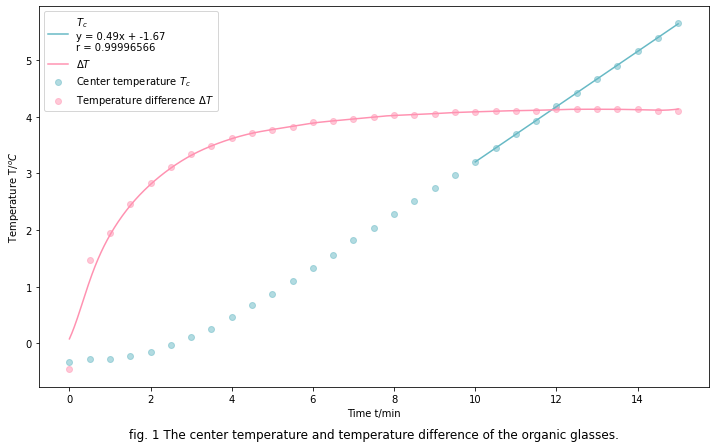

In [7]:
dfog = pd.read_csv('B2-Data/Tog.csv')
par = 1/0.039
dfog['Tc'] = dfog['uTc']*par
dfog['dT'] = dfog['udT']*par

fig = plt.figure(figsize=(12, 7))
t = np.arange(0, 15.5, 0.5)
plt.scatter(t, dfog['Tc'], color='#67b9c5', alpha = 0.5, label='Center temperature $T_c$')
plt.scatter(t, dfog['dT'], color='#ff92b1', alpha = 0.5, label='Temperature difference $\Delta T$')

# Tc
Tc_func = np.polyfit(t[20:], dfog['Tc'][20:], deg=1)
t_dns = np.linspace(10, 15, 100)
Tc_reg = np.polyval(Tc_func, t_dns)

r = np.corrcoef(t[20:], dfog['Tc'][20:])[0,1]
A1, A2 = tuple(Tc_func)
plt.plot(t_dns, Tc_reg, color='#67b9c5', 
                          label='$T_c$ \ny = {:.2f}x + {:.2f}\nr = {:.8f}'
                          .format(A1, A2, r))

# dT
t_dns = np.linspace(0, 15, 1000)
itp_func = Rbf(t, dfog['dT'], smooth=0.5)

dT_itp = itp_func(t_dns)
plt.plot(t_dns, dT_itp, color='#ff92b1', label='$\Delta T$')


plt.legend()

plt.xlabel('Time t/min')
plt.ylabel('Temperature T/$^oC$')
plt.title('fig. 1 The center temperature and temperature difference of the organic glasses.', y=-0.15)
plt.savefig(r'B2-Output\fig.1.png', bbox_inches = 'tight', dpi=300)

### 1.3 lam & c

In [21]:
dT = 0.160*par
qc = U**2/(2*r0*(S/A))
k = 0.49/60
lam = U**2*R/(4*dT*r0*(S/A))
c = U**2/((2*r0*(S/A)) * (rho_og*R*k))
print(dT)
print(qc)
print(lam)
print(c)

4.102564102564103
139.94192960659615
0.17166282918164133
1423.5019598728952


In [9]:
Rs, Ss = sp.symbols('Rs Ss') 
subs = {'Rs':R, 'Ss':S} 

In [10]:
F_lam = U**2*Rs/(4*dT*r0*(Ss/A))
F_lam_R, F_lam_S = tuple(sp.diff(F_lam, i).evalf(subs = subs) for i in ['Rs', 'Ss'])  
print(F_lam_R, F_lam_S)

# S
Slam = ( (SR*F_lam_R)**2 + (SS*F_lam_S)**2 )**(1/2)
print('Slam={}'.format(Slam))

16.9395520038757 -21.1466671634220
Slam=0.000328130817590940


In [11]:
F_c = U**2/((2*r0*(Ss/A)) * (rho_og*Rs*k))
F_c_R, F_c_S = tuple(sp.diff(F_c, i).evalf(subs = subs) for i in ['Rs', 'Ss'])  
print(F_c_R, F_c_S)

# S
Sc = ( (SR*F_c_R)**2 + (SS*F_c_S)**2 )**(1/2)
print('Sc={}'.format(Sc))

-141487.369396806 -176627.239479405
Sc=2.74070802984300


## 2. rubber

### 2.1 Size

In [12]:
dfLIST = []
path = r'B2-Data/'
file = glob.glob(os.path.join(path, 'rb**.csv'))
for f in file:
    dfLIST.append(pd.read_csv(f))
    
def F(df):
    w, t = tuple((df.describe().loc['mean'])*0.001)
    Sw, St = tuple((df.describe().loc['std'])*0.001)
    return [w, t, Sw, St]

size = pd.DataFrame(columns=['index', 'width', 'thickness', 'Sw', 'St'])
size.set_index('index', drop=True, inplace=True)
for idx in range(len(dfLIST)):
    df = dfLIST[idx]
    print(F(df))
    size.loc[len(size)] = F(df)

R = (size.iloc[1,1] + size.iloc[3,1])/2
S = ((size.iloc[1,0])**2 + (size.iloc[3,0])**2)/2
print(S, R)

R1 = size.iloc[1,1] 
SR1 = size.iloc[1,3] 
R2 = size.iloc[3,1]
SR2 = size.iloc[3,3]
W1 = size.iloc[1,0]
SW1 = size.iloc[1,2]
W2 = size.iloc[3,0]
SW2 = size.iloc[3,2]

size

[0.08942750000000001, 0.010045, 0.00021669871557841158, 2.0816659994661738e-05]
[0.08938249999999999, 0.0100625, 6.70198975429488e-05, 1.7078251276599745e-05]
[0.089695, 0.0102325, 5.4467115461224734e-05, 2.0615528128087864e-05]
[0.0892675, 0.010067500000000002, 0.00020516253719104666, 9.574271077563178e-06]
0.007978958931249999 0.010065000000000001


,width,thickness,Sw,St
index,,,,
0,0.089428,0.010045,0.000217,0.000021
1,0.089382,0.010063,0.000067,0.000017
2,0.089695,0.010233,0.000054,0.000021
3,0.089267,0.010068,0.000205,0.000010


In [13]:
R1s, R2s, W1s, W2s = sp.symbols('R1s R2s W1s W2s') 
subs = {'R1s': R1, 'R2s': R2, 'W1s': W1, 'W2s': W2} 

In [14]:
F_R = (R1s + R2s)/2
F_R_R, F_R_S = tuple(sp.diff(F_R, i).evalf(subs = subs) for i in ['R1s', 'R2s'])  
print(F_R_R, F_R_S)

# S
Sa = ( (SR1*F_R_R)**2 + (SR2*F_R_S)**2 )**(1/2)
u = 0.00001/(3**(1/2)) 
Sb = ( (u*F_R_R)**2 + (u*F_R_S)**2 )**(1/2)
SR = ( (Sa)**2 + (Sb)**2 )**(1/2)
print('Sa={}\nSb={}\nS={}'.format(Sa, Sb, SR))

0.500000000000000 0.500000000000000
Sa=0.00000978945010372574
Sb=0.00000408248290463863
S=0.0000106066017177983


In [15]:
F_S = (W1s**2 + W2s**2)/2
F_S_R, F_S_S = tuple(sp.diff(F_S, i).evalf(subs = subs) for i in ['W1s', 'W2s'])  
print(F_S_R, F_S_S)

# S
Sa = ( (SW1*F_S_R)**2 + (SW2*F_S_S)**2 )**(1/2)
u = 0.00001/(3**(1/2)) 
Sb = ( (u*F_S_R)**2 + (u*F_S_S)**2 )**(1/2)
SS = ( (Sa)**2 + (Sb)**2 )**(1/2)
print('Sa={}\nSb={}\nS={}'.format(Sa, Sb, SS))

0.0893825000000000 0.0892675000000000
Sa=0.0000192691531274057
Sb=7.29335722021530E-7
S=0.0000192829508333871


### 2.2 $T$ & $\Delta T$

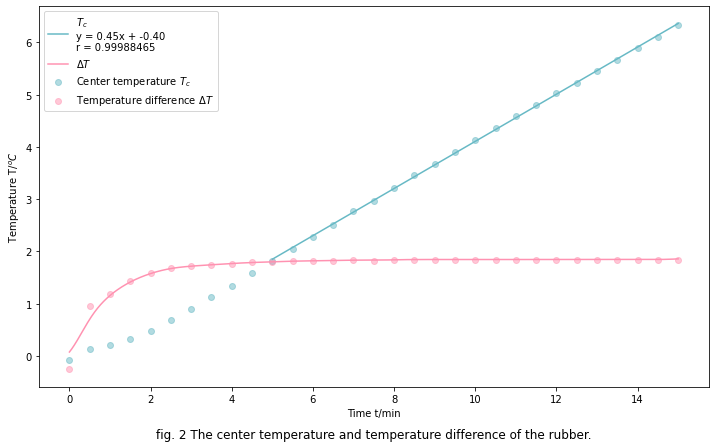

In [16]:
dfrb = pd.read_csv('B2-Data/Trb.csv')
par = 1/0.039
dfrb['Tc'] = dfrb['uTc']*par
dfrb['dT'] = dfrb['udT']*par

fig = plt.figure(figsize=(12, 7))
t = np.arange(0, 15.5, 0.5)
plt.scatter(t, dfrb['Tc'], color='#67b9c5', alpha = 0.5, label='Center temperature $T_c$')
plt.scatter(t, dfrb['dT'], color='#ff92b1', alpha = 0.5, label='Temperature difference $\Delta T$')

# Tc
Tc_func = np.polyfit(t[10:], dfrb['Tc'][10:], deg=1)
t_dns = np.linspace(5, 15, 100)
Tc_reg = np.polyval(Tc_func, t_dns)

r = np.corrcoef(t[10:], dfrb['Tc'][10:])[0,1]
A1, A2 = tuple(Tc_func)
plt.plot(t_dns, Tc_reg, color='#67b9c5', 
                          label='$T_c$ \ny = {:.2f}x + {:.2f}\nr = {:.8f}'
                          .format(A1, A2, r))

# dT
t_dns = np.linspace(0, 15, 1000)
itp_func = Rbf(t, dfrb['dT'], smooth=0.5)

dT_itp = itp_func(t_dns)
plt.plot(t_dns, dT_itp, color='#ff92b1', label='$\Delta T$')


plt.legend()

plt.xlabel('Time t/min')
plt.ylabel('Temperature T/$^oC$')
plt.title('fig. 2 The center temperature and temperature difference of the rubber.', y=-0.15)
plt.savefig(r'B2-Output\fig.2.png', bbox_inches = 'tight', dpi=300)

### 1.3 lam & c

In [22]:
dT = 0.072*par
qc = U**2/(2*r0*(S/A))
k = 0.45/60
lam = U**2*R/(4*dT*r0*(S/A))
c = U**2/((2*r0*(S/A)) * (rho_rb*R*k))
print(dT)
print(qc)
print(lam)
print(c)

1.846153846153846
139.94192960659615
0.38147295373698076
1349.2302904155124


In [18]:
Rs, Ss = sp.symbols('Rs Ss') 
subs = {'Rs':R, 'Ss':S} 

In [19]:
F_lam = U**2*Rs/(4*dT*r0*(Ss/A))
F_lam_R, F_lam_S = tuple(sp.diff(F_lam, i).evalf(subs = subs) for i in ['Rs', 'Ss'])  
print(F_lam_R, F_lam_S)

# S
Slam = ( (SR*F_lam_R)**2 + (SS*F_lam_S)**2 )**(1/2)
print('Slam={}'.format(Slam))

37.9009392684531 -47.8098655506200
Slam=0.00100574943732479


In [20]:
F_c = U**2/((2*r0*(Ss/A)) * (rho_og*Rs*k))
F_c_R, F_c_S = tuple(sp.diff(F_c, i).evalf(subs = subs) for i in ['Rs', 'Ss'])  
print(F_c_R, F_c_S)

# S
Sc = ( (SR*F_c_R)**2 + (SS*F_c_S)**2 )**(1/2)
print('Sc={}'.format(Sc))

-154002.530294799 -194265.377322142
Sc=4.08665223554259
